# Разработка алгоритма преобразования данных страховой компании

Цель проекта:

> Разработать алгоритм преобразования исходных данных, позволяющий, ограничить непосредственный доступ "сторонних лиц" к информации, а также сохранить качество моделей машинного обучения. 

Звучит крайне увлекательно, хоть, на первый взгляд, и совершенно не понятно. Особенно в области "защиты" данных посредством преобразований. 

Так или иначе - приступим. Заведем отдельную строку для импорта библиотек и посмотрим на имеющиеся у нас данные.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import random
from random import randint

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import cross_val_predict

## 1. Загрузка данных

In [2]:
ins_data = pd.read_csv("/datasets/insurance.csv")
ins_data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
ins_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


4 входных признака:
- пол (0, 1)
- возраст 
- зарплата
- число членов семьи (от 0 и выше)

Целевой признак:
- количество страховых выплат за последние 5 лет (обращений или выплат?)

### Анализ исходных данных

В первую очередь, нам необходимо определить характер решаемой задачи - это задача регрессии или классификации. С точки зрения исходных данных (распределения значений признаков приведены на гистограммах, расположенных ниже), безусловно, нам следует решать рассматриваемую задачу как задачу регрессии - т.к. целевой признак (пусть и дискретный) принимает целых 6 различных вариантов значений обращения за страховыми выплатами - от 0 до 5 с шагом 1. 

Теоретически, мы можем превратить эту задачу в задачу классификации - разделить объекты на 2 группы по целевому признаку - обращался за выплатой (там будут 0) и не обращался за выплатой (там будут значения 1-5). Однако, раз задачи "оптимизации" модели и всего проекта в целом не стоит, обратимся к алгоритмам регрессии. 

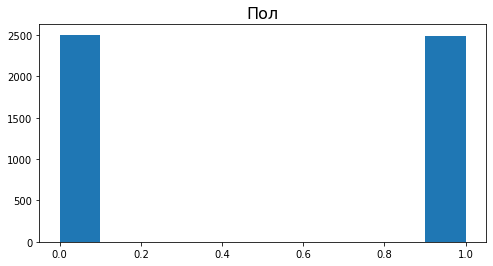

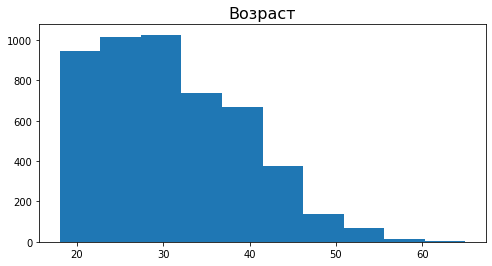

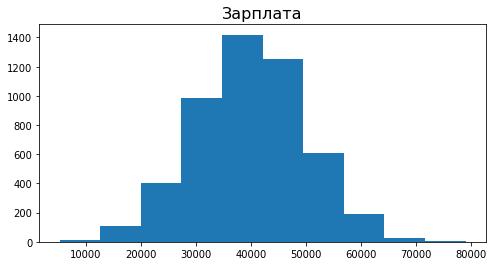

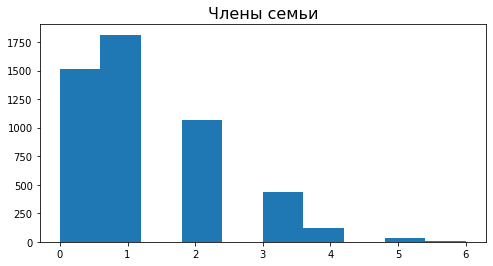

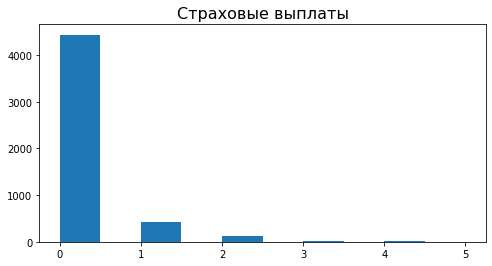

In [4]:
for column in ins_data.columns:
    plt.figure(figsize = (8,4))
    plt.hist(ins_data[column])
    plt.title(column, fontsize = 16)
    plt.show()

Один из важных критериев "корректной" предобработки данных заключается в необходимости СОХРАНЕНИЯ характера распределения значений "предобрабатываемых" признаков - полагаю, что этой логикой мы можем воспользоваться и в нашем случае. 

Пробежавшись "по верхам" по возможным способам защиты данных и основным критериям, предъявляемым к методам защиты, я сформулировал следующие требования к реализуемому алгоритму:

1) Для кодирования мы будем использовать метод шифрования с помощью ключа. Соответственно, для расшифровки данных нам потребуется ключ, который будет каждый раз генерироваться случайным образом - для предотвращения его возможной компрометации; 

2) сложность шифрования должна быть таковой, чтобы единственным способом "наверняка" получить доступ к информации, был перебор по всем имеющимся значениям, причем реализация данного способа не должна быть технически ВОЗМОЖНА с учетом существующих вычислительных мощностей (и т.д.). Обобщая - вариантов ВОЗМОЖНОГО ключа должно быть БОЛЬШЕ, чем можно будет БЫСТРО вычислить (подобрать) на существующем "железе";

3) Объем закодированных данных не должен существенно отличаться от объема ИСХОДНЫХ данных. В нашем случае, более того, число объектов и ФОРМА датасета у закодированных и исходных данных должна совпадать (4 столбца-признака, 5000 строк). 

Тем не менее, пока по-прежнему мало что понятно. Но и это мы исправим! Вперёд!

## 2. Умножение матриц

А пока займемся умножением матриц в соответствии с заданием.

Нам необходимо умножить матрицу признаков на обратимую матрицу и узнать, изменятся ли показатели качества модели линейной регрессии. Как говорил мой дед - "Я твой дед". Если не можешь ответить на вопрос - экспериментируй. 

НАЙДЕМ ответ на поставленный вопрос. План действий следующий:
- получить обратимую матрицу (какую-нибудь) соответствующего размера. Соответствующий размер - такой, чтобы после умножения матрицу на матрицу, получить матрицу "преобразованных" признаков того же размера, что и исходная (5000 на 4). 

$$ (a × c) @ (c × b) = (a × b) $$

- А учитывая тот факт, что размеры матрицы-произведения должны совпадать с размерами матрицы признаков (5000 × 4), очевидно, что $b = c = 4$. Искомая обратимая матрица будет размерами 4 × 4. Обратимая матрица - всегда квадратная (!)

> Проверку обратимости матрицы выполним с помощью np.linalg.inv()

Разделим датасет на "фичи" и целевой признак.

In [5]:
features = ins_data.drop(['Страховые выплаты'], axis = 1)
target = ins_data['Страховые выплаты']
features.shape

(5000, 4)

Сгенерируем матрицу и проверим её на обратимость.

In [6]:
n = len(features.columns)

matrix = [[random.randint(0, 9) for r in range(n)] for s in range(n)]

try:
    matrix_inv = np.linalg.inv(matrix)
    print("Обратимая матрица получена")
    print(matrix)
except LinAlgError:
    print("Сгенерирована НЕобратимая матрица. Запустите генератор-матриц ещё раз.")

Обратимая матрица получена
[[1, 9, 4, 4], [3, 4, 4, 6], [2, 1, 1, 2], [8, 7, 5, 7]]


In [7]:
matrix_mult = matrix

Качество модели будем сверять на основании показателя MSE.

Но в первую очередь, нам необходимо её подготовить, обучить и с помощью "cross_val_predict" получить значения предсказаний для всего датасета в целом - вместо того, чтобы самостоятельно дробить его на части и много раз "обучать - предсказывать". Для ускорения работы нашел в документации параметр "n_jobs", который позволяет использовать более одного процессора для расчетов (1 - один процессор, -1 - все процессоры).

In [8]:
model = LinearRegression()
predictions = cross_val_predict(model, features, target, cv = 5, n_jobs = -1)

In [9]:
MSE = mean_squared_error(target, predictions)
MSE

0.12357754506264323

Значение MSE для признаков без изменения получили - теперь преобразуем признаки с помощью "домножения" на обратимую матрицу и посмотрим на значение MSE после этого.

In [10]:
features_np = np.array(features)
features_np

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

In [11]:
features_transf_np = features_np.dot(matrix_mult)
features_transf_np

array([[99332., 49780., 49773., 99457.],
       [76146., 38191., 38189., 76283.],
       [42087., 21116., 21116., 42174.],
       ...,
       [67876., 33994., 33990., 67934.],
       [65491., 32818., 32807., 65557.],
       [81293., 40728., 40721., 81379.]])

Посмотрим на распределения признаков после перемноженяия (для личного интереса).

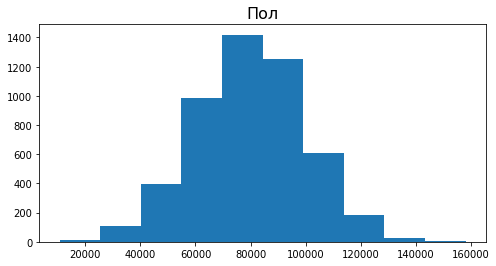

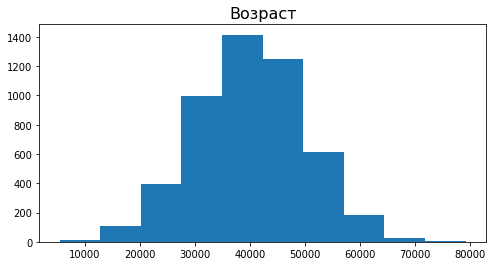

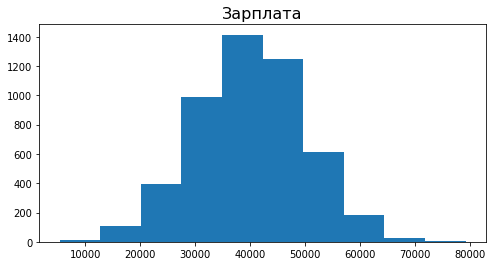

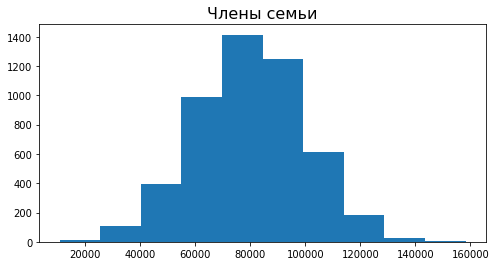

,Пол,Возраст,Зарплата,Члены семьи
0,99332.0,49780.0,49773.0,99457.0
1,76146.0,38191.0,38189.0,76283.0
2,42087.0,21116.0,21116.0,42174.0
3,83479.0,41798.0,41794.0,83540.0
4,52285.0,26221.0,26216.0,52372.0
...,...,...,...,...
4995,71500.0,35826.0,35822.0,71582.0
4996,104910.0,52543.0,52541.0,105011.0
4997,67876.0,33994.0,33990.0,67934.0
4998,65491.0,32818.0,32807.0,65557.0


In [12]:
features_transf_df = pd.DataFrame(data = features_transf_np, columns = features.columns)

for column in features_transf_df.columns:
    plt.figure(figsize = (8,4))
    plt.hist(features_transf_df[column])
    plt.title(column, fontsize = 16)
    plt.show()
    
features_transf_df

#### Новость с пометкой "Молния"!!!

После перемножения, распределения значений ВСЕХ признаков "магическим образом" стали "нормальными", причем по форме они близки друг к другу как 2 капли воды. Особенно занимательно это осознавать в отношении признака "Пол", поскольку ему "удалось" превратиться из распределения "в 2 столбца" (М и Ж) в "полноценный" признак.

Проверим, как отразится это "изменение на процессе прогнозирования значений.

Обучим модель заново и с помощью кросс-валидации найдем предсказания для всего датасета.

In [13]:
model_transf = LinearRegression()
predictions_transf = cross_val_predict(model_transf, features_transf_df, target, cv = 5, n_jobs = -1)

In [14]:
MSE_transf = mean_squared_error(target, predictions_transf)
MSE_transf

0.12357754506264357

In [15]:
print("Разница между значениями MSE для исходного и преобразованного датасетов составляет:", MSE - MSE_transf)

Разница между значениями MSE для исходного и преобразованного датасетов составляет: -3.3306690738754696e-16


*Амаяк Акопян has entered the chat.*

> Ловкость рук и никакого мошенства!

*Амаяк Акопян has left the chat.*

Неожиданная и пока совершенно непонятная ситуация. Модели, обученные на исходном и преобразованном с помощью обратимой матрицы датасетах, обладают идентичным качеством прогнозирования (с точностью до 15 знака после запятой). 

По-прежему мало что понимая, мы можем ответить на поставленный ранее вопрос.

> Нет, не изменится. 

Но остается ещё один неразрешенный момент:

>... как связаны параметры линейной регрессии в исходной задаче и в преобразованной?

Чтобы ответить на него нам необходимо определить значения параметров $w$ и $w_0$ (вектор весов и величина сдвига) для обеих полученных моделей.

Воспользуемся формулой для нахождения вектора весов $w$ + свободного члена $w_0$ (элемент №0):

$$w = (X^T X)^{-1} X^T y$$

где

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

In [16]:
X = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
y = target
w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(target)

columns_list = ['w0', 'w1', 'w2', 'w3', 'w4']
w_compar = pd.DataFrame(data = [], columns = columns_list)
w_compar.loc[0] = w

In [17]:
X_transf = np.concatenate((np.ones((features_transf_np.shape[0], 1)), features_transf_np), axis=1)
y = target
w_transf = np.linalg.inv(X_transf.T.dot(X_transf)).dot(X_transf.T).dot(target)

w_compar.loc[1] = w_transf
w_compar

,w0,w1,w2,w3,w4
0,-0.938236,0.007926,0.035708,-1.700805e-07,-0.013568
1,-0.938235,-0.009706,-0.006875,1.346727e-02,0.006409


Первое, что следует отметить - это равенство значений сдвига для полученных моделей. Следовательно мы можем помыслить следующее - для "облака распределения значений" высокого порядка (которое уже невозможно визуально воспроизвести) - для 4 входных признаков, преобразование значений посредством домножения на обратимую матрицу приводит к изменению НАКЛОНА описывающей кривой (изменение весов признаков) относительно "нулевой" плоскости (опять же, существующей только в нашей голове), однако РАССТОЯНИЕ (он же сдвиг) относительно оси ЦЕЛЕВОГО признака для соответствующей кривой не меняется. 

Кроме того, следует отметить, что домножение матрицы на обратимую матрицу позволил существенно СНИЗИТЬ разброс значений весов - так, если для исходной матрицы вес признака №3 был в 10 000 - 100 000 раз меньше остальных (сказывается существенная разница между исходными значениями признаков - возраст с диапазоном 0 - 100 и зарплата, измеряемая десятками тысяч), то для преобразованной матрицы вес 3-го признака находится примерно на том же уровне, что и у всех остальных.

Вероятно также, что вектор весов модели, обученной на преобразованных данных, равен произведению вектора весов "исходной" модели и используемой "обратимой матрицы". Это можно сделать с помощью математики, однако, если есть возможность воспользоваться "аппаратными мозгами" - почему бы и нет.

In [18]:
w_compar_no_w0 = w_compar.drop(['w0'], axis = 1)
w_no_w0 = w_compar_no_w0.loc[0].values
w_compar_no_w0.loc[2] = w_no_w0.dot(matrix_mult)
w_compar_no_w0

,w1,w2,w3,w4
0,0.007926,0.035708,-1.700805e-07,-0.013568
1,-0.009706,-0.006875,1.346727e-02,0.006409
2,0.006509,0.119192,1.066980e-01,0.150979


Увы, но наше последнее предположение оказалось неверным. Но мы не отчаиваемся и воспользуемся секретным приемом. МАТЕМАТИКОЙ!

### 2.1 Взаимосвязь между векторами весов

Добавим математики и аналитических моментов в происходящее.

Для исходной матрицы признаков, вектор весов (которому соответствует минимальное значение функции потерь), определяется по формуле:

$$w = (X^T X)^{-1} X^T y$$

В свою очередь, если мы домножаем матрицу признаков $X$ на обратимую (квадратную) матрицу $P$, тогда формула приобретает следующий вид:

$$w_1 = ((XP)^T XP)^{-1} (XP)^T y$$

Поскольку мы ищем взаимосвязь между значениями, найдем отношение $w_1$ к $w$:

$$ \frac{w_1}{w} = \frac{((XP)^T XP)^{-1} (XP)^T y}{(X^T X)^{-1} X^T y} = \frac{(P^T X^T X P)^{-1} P^T X^T y}{(X^T X)^{-1} X^T y} = \frac{(P^T)^{-1} (X^T X)^{-1} (P)^{-1} P^T X^T y}{(X^T X)^{-1} X^T y} = (P^T)^{-1} (P)^{-1} P^T = P^{-1} $$

Таким образом:
$$ w_1 = P^{-1} w $$

Проверим наши расчеты МАТЕМАТИЧЕСКИ!

In [19]:
w_first = w_compar_no_w0.loc[0].values
w_scnd = w_compar_no_w0.loc[1].values

In [20]:
matrix_np = np.array(matrix)
w_scnd_calc = np.linalg.inv(matrix_np).dot(w_first)
w_compar_no_w0.loc[3] = w_scnd_calc
w_compar_no_w0

,w1,w2,w3,w4
0,0.007926,0.035708,-1.700805e-07,-0.013568
1,-0.009706,-0.006875,1.346727e-02,0.006409
2,0.006509,0.119192,1.066980e-01,0.150979
3,-0.009706,-0.006875,1.346727e-02,0.006409


Ведь я ещё не говорил в этом проекте "Бинго!"?

БИНГО!

Соотношение между значениями найдено.

$$ w_1 = P^{-1} w $$

где $P$ - обратимая матрица, на которую умножается матрица признаков $w$.

Следующий момент - нужно понять, почему равны значения сдвига. Обратимся к формулам получения вектора предсказаний.

$$ A_1 = X w + w_0 $$

$$ A_2 = X_1 w_1 + w_{01} = X P P^{-1} w + w_{01} = X w + w_{01} $$

Таким образом, равенство предсказаний моделей возможно только при равенстве свободных членов, т.к. часть модели, связанная с матрицей признаков, идентична для обеих моделей. 

## 3. Алгоритм преобразования

> Предложите алгоритм преобразования данных для решения задачи. Обоснуйте, почему качество линейной регрессии не поменяется.

**Обоснование**

Как мы поняли, домножение матрицы признаков на обратимую матрицу не приводит к изменению качества предсказаний модели машинного обучения. 

Однако, обращаясь к приведенным ранее принципам защиты информации:

> 2) сложность шифрования должна быть таковой, чтобы единственным способом "наверняка" получить доступ к информации, был перебор по всем имеющимся значениям, причем реализация данного способа не должна быть технически ВОЗМОЖНА с учетом существующих вычислительных мощностей (и т.д.). Обобщая - вариантов ВОЗМОЖНОГО ключа должно быть БОЛЬШЕ, чем можно будет БЫСТРО вычислить (подобрать) на существующем "железе";

> 3) Объем закодированных данных не должен существенно отличаться от объема ИСХОДНЫХ данных. В нашем случае, более того, число объектов и ФОРМА датасета у закодированных и исходных данных должна совпадать (4 столбца-признака, 5000 строк).

Мы можем попробовать посчитать примерное время, за которое может быть подобран ключ на среднестатистическом компьютере (у нас будут "русские хакеры" со среднестатистическим 8-ядерным компьютером). 

Итак, математика!

1. Количество вариантов матрицы размером 4 х 4 при варьировании каждого значения в диапазоне от 0 до 9 составляет $10^{16}$. 
2. Мощность современного "среднего компьютера" по данным википедии (да, да, я знаю - брать информацию из википедии - не самый лучший вариант) составляет 0.1 терафлопс или $10^{11}$ операций в секунду. Не знаю, это относится к 1 ядру или ко всем 8, но предположу, что только к 1. Следовательно, наш среднестатистический "хакерский" компьютер может выполнять $8 × 10^{11}$ операций в секунду. 
3. Следовательно, для того, что бы подобрать ключ ему потребуется: 
$$ 10^{16}\;/\;(8 × 10^{11}) = 12 500\;секунд\;или\;примерно\;3.5\;часа$$

Выглядит неплохо, однако, если мы предположим работу в "крупной компании" с "большими объемами" (и ценностью) данных, нам необходимо увеличить данное значение ТАК, чтобы вероятность разгадки была "КРАЙНЕ МАЛА".

Вероятно, нам удастся этого достичь, если мы добавим ЕЩЁ одну матрицу в процесс кодирования. И будет у нас эдакий КЛЮЧ + КЛЮЧ (Двойной ключ, вау!). Для этого мы можем генерировать матрицу 8 на 4 и резать её на 2. Умножать 2 матрицу признаков 2 раза. В таком случае, число вариантов вырастает до 10 в 32 степени, а значит время вычислений улетает в потолок и становится равным 1+ млрд. лет при использовании метода "перебора значений". + добавляется такой критерий как ПОСЛЕДОВАТЕЛЬНОСТЬ использования ключей => это ещё дополнительное удвоение.

Однако, мы к настоящему моменту не знаем, сработает ли данный подход - потому, проверим его.

In [21]:
n = len(features.columns)

matrix_doubled = [[random.randint(0, 9) for r in range(n)] for s in range(2*n)]
matrix_1 = matrix_doubled[:4]
matrix_2 = matrix_doubled[4:]

try:
    key_matrix_1 = np.linalg.inv(matrix_1)
    key_matrix_2 = np.linalg.inv(matrix_2)
    
    print("Обратимые матрицы получены.")
    print(matrix_1)
    print(matrix_2)
except LinAlgError:
    print("Сгенерирована 1 или 2 НЕобратимые матрицы. Запустите генератор-матриц ещё раз.")

Обратимые матрицы получены.
[[4, 8, 0, 6], [4, 5, 5, 6], [1, 3, 2, 1], [2, 8, 8, 5]]
[[0, 9, 0, 7], [8, 8, 6, 8], [2, 3, 7, 4], [9, 2, 1, 9]]


Пара обратимых матриц получены. Умножаем матрицу признаков на эти матрицы (сначала на 1ю, потом на 2ю).

In [22]:
features_double_transf = features_np.dot(matrix_1).dot(matrix_2)
features_double_transf

array([[1839707., 2038051., 1639874., 2386923.],
       [1410909., 1562854., 1257375., 1830687.],
       [ 780016.,  863987.,  695059., 1012118.],
       ...,
       [1256630., 1392192., 1120338., 1630350.],
       [1212681., 1343426., 1081043., 1573335.],
       [1505355., 1667712., 1341951., 1953077.]])

In [23]:
features_double_transf = features_np.dot(matrix_1).dot(matrix_2)
features_double_transf

array([[1839707., 2038051., 1639874., 2386923.],
       [1410909., 1562854., 1257375., 1830687.],
       [ 780016.,  863987.,  695059., 1012118.],
       ...,
       [1256630., 1392192., 1120338., 1630350.],
       [1212681., 1343426., 1081043., 1573335.],
       [1505355., 1667712., 1341951., 1953077.]])

In [24]:
model_double_transf = LinearRegression()
predictions_double_transf = cross_val_predict(model_double_transf,
                                              features_double_transf, target, cv = 5, n_jobs = -1)

In [25]:
MSE_double_transf = mean_squared_error(target, predictions_double_transf)
MSE_double_transf

0.12357754506264505

Победа! Даже двойное перемножение не сказалось на качестве модели. 

Соберем полученные функции, мысли и результаты в "конечный" алгоритм, которые позволит закодировать исходные данные.

В качестве входного значения получаем - 2 датасета с признаками и целевым признаком. 

На выходе:
- преобразованный датасет;
- ключи расшифровки (обратные к полученным матрицы) с учетом последовательности применения (сначала вторая, потом первая);
- показатель качества модели линейной регрессии для исходных данных;
- показатель качества модели для преобразованных данных.

В качестве критерия качества воспользуемся $R^2$ вместо $MSE$.

## 4. Проверка алгоритма

Как мы помним, порядок умножения крайне важен, т.к. при его несоблюдении, вместо восстановления значений, мы можем получить следующее:

In [26]:
round(pd.DataFrame(data = (features_double_transf @ key_matrix_1 @ key_matrix_2)))

,0,1,2,3
0,-8989.0,102513.0,-44730.0,-78753.0
1,-6889.0,78625.0,-34336.0,-60391.0
2,-3808.0,43469.0,-18990.0,-33385.0
3,-7554.0,86104.0,-37541.0,-66158.0
4,-4732.0,53983.0,-23568.0,-41466.0
...,...,...,...,...
4995,-6469.0,73780.0,-32188.0,-56681.0
4996,-9493.0,108233.0,-47205.0,-83155.0
4997,-6142.0,70019.0,-30534.0,-53797.0
4998,-5927.0,67574.0,-29474.0,-51916.0


Вместо:

In [27]:
round(pd.DataFrame(data = (features_double_transf @ key_matrix_2 @ key_matrix_1)))

,0,1,2,3
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,-0.0,29.0,21000.0,-0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,-0.0
...,...,...,...,...
4995,-0.0,28.0,35700.0,2.0
4996,-0.0,34.0,52400.0,1.0
4997,-0.0,20.0,33900.0,2.0
4998,1.0,22.0,32700.0,3.0


В нашем случае округление значений до целочисленных имеет смысл, т.к. в противном случае вместо 2 полов, закодированных как 0 и 1, мы можем получить множество промежуточных значений вида $1.25 * 10^{-12}$, вызванные погрешностями процессов кодирования и декодирования.

Напишем алгоритм кодировки.

In [28]:
def coder(features, target):
    
    n = len(features.columns)
    matrix_doubled = [[random.randint(0, 9) for r in range(n)] for s in range(2*n)]
    matrix_1 = matrix_doubled[:4]
    matrix_2 = matrix_doubled[4:]

    try:
        
        # здесь нет ошибки, т.к. на выход будет подаваться сначала обратная матрица
        # для второй кодирующей матрицы, и только потом для первой.
        
        key_matrix_2 = np.linalg.inv(matrix_1)
        key_matrix_1 = np.linalg.inv(matrix_2)
    except LinAlgError:
        print("Ошибка при генерации ключей. Перезапустите кодировщик.")
    
    features_coded = features @ matrix_1 @ matrix_2
    
    model = LinearRegression()
    predictions = cross_val_predict(model, features, target, cv = 5, n_jobs = -1)
    r_2_score = r2_score(target, predictions)
    
    model_coded = LinearRegression()
    predictions_coded = cross_val_predict(model_coded, features_coded, target, cv = 5, n_jobs = -1)
    r_2_score_coded = r2_score(target, predictions_coded)
    
    return features_coded , key_matrix_1, key_matrix_2, r_2_score, r_2_score_coded
    
coded_data = []
key_1 = []
key_2 = []

r_2 = 0 
r_2_score = 0

coded_data, key_1, key_2, r_2, r_2_score = coder(features, target)

Посмотрим, что получилось на выходе.

In [29]:
coded_data

,0,1,2,3
0,1092376.0,5461854.0,1191794.0,4766802.0
1,837300.0,4186427.0,913531.0,3653733.0
2,462812.0,2313973.0,504957.0,2019567.0
3,918012.0,4590127.0,1001519.0,4005933.0
4,575000.0,2874948.0,627352.0,2509128.0
...,...,...,...,...
4995,786208.0,3931086.0,857750.0,3430794.0
4996,1153764.0,5768783.0,1258735.0,5034657.0
4997,746384.0,3731990.0,814286.0,3257010.0
4998,720068.0,3600501.0,785593.0,3142215.0


Выглядит внушительно и совершенно непонятно.

In [30]:
r_2, r_2_score

(0.4238701651189615, 0.4238701651191713)

Значения R2 хоть и "КРАЙНЕ МАЛЫ!", тем не менее, они при этом всём и крайне близки друг к другу. Первый расхождения - на 12 знаке после запятой. В нашем случае такой точности вполне достаточно. 

Проверим теперь возможность декодирования датасета в обратную сторону.

In [31]:
keys = [key_1, key_2]

def decoder(coded_features, key_list):
    decoded_features = coded_features
    for key in key_list:
        decoded_features = decoded_features @ key
    
    decoded_features_int = decoded_features
    return decoded_features_int

In [32]:
back_to_features = decoder(coded_data, keys)
back_to_features.columns = features.columns
back_to_features = abs(back_to_features.round(0))
back_to_features

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
...,...,...,...,...
4995,0.0,28.0,35700.0,2.0
4996,0.0,34.0,52400.0,1.0
4997,0.0,20.0,33900.0,2.0
4998,1.0,22.0,32700.0,3.0


На первый взгляд - очень похоже, что восстановление прошло успешно. Проверим, совпадают ли данные 

In [33]:
delta = features - back_to_features
for column in delta.columns:
    print(delta[column].value_counts())

0.0    5000
Name: Пол, dtype: int64
0.0    5000
Name: Возраст, dtype: int64
 0.000000e+00    4960
 3.637979e-12      35
-7.275958e-12       3
 7.275958e-12       2
Name: Зарплата, dtype: int64
0.0    5000
Name: Члены семьи, dtype: int64


Погрешности обнаружены в столбце №2 - "Возраст". 
Из 5000 значений 40 восстановлены "криво", с отклонением $10^{-12}$. Полагаю, такая точность на таком массиве данных (99.2%) допустима. 

> Спасибо за внимание!